In [1]:
import h5py
import matplotlib.pyplot as plt

import numpy as np
import time
from skimage.feature import hog
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.3.0


# Se cargan los datos.

In [2]:
# Set 1 --> 1-766
# Set 2 --> 767-1532
# Set 3 --> 1533-2298
# Set 4 --> 2299-3064

# 0 --> Meningioma
# 1 --> Glioma
# 2 --> Pituitary Tumor 

# El máximo valor encontrado en las imagenes es m = 12728. El computador se queda pegado cuando se quiere
# normalizar.

def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()
    

# Arreglo de matrices.
X = []
# Arreglo con valores en {0,1,2} que guarda el label de cada matriz en X. 3065
y = []
# Limpiar datos.
aux1 = np.arange(955, 960)
aux2 = np.arange(1070, 1090)
aux3 = np.arange(1200, 1220)

ti = time.time()
for i in np.arange(1, 3065):
    if (i not in aux1) and (i not in aux2) and (i not in aux3):
        j = int(np.floor((i - 1)/766) + 1)
        a = read_matlab('set' + str(j) + '/' + str(i) + '.mat')
        # Se guarda la matriz
        X.append(np.array(a['cjdata']['image']))
        # Se le resta uno para que quede en formato {0,1,2}
        y.append(a['cjdata']['label'][0][0] - 1)
tfin = time.time()
print('Tiempo en obtener imágenes : ' + str((tfin-ti) / 60) + ' minutos' ) 

Tiempo en obtener imágenes : 3.705299945672353 minutos


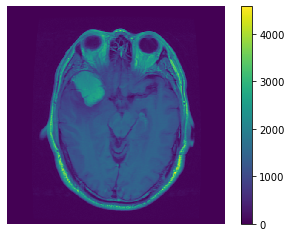

In [4]:
plt.imshow(X[30])
plt.axis('off')
plt.colorbar()
plt.show()

In [5]:
X = np.array(X)
y = np.array(y)
X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=0.30, random_state=6)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.50, random_state=7)

# calibración de hiperparámetros.

Entrenamos los modelos considerados sobre el set de validación para calibrar el number of epochs.

In [2]:
################################## NN-1 ################################## 

# Clear
tf.keras.backend.clear_session()

# Model
NN1_c = tf.keras.Sequential()

# Input layer
NN1_c.add(tf.keras.layers.Flatten(input_shape=(512, 512)))

# Hidden layer
NN1_c.add(tf.keras.layers.Dense(100, activation='relu'))

# Output layer
NN1_c.add(tf.keras.layers.Dense(3))

################################## NN-2 ################################## 

# Model
NN2_c = tf.keras.Sequential()

# Add input layer.
NN2_c.add(tf.keras.layers.Flatten(input_shape=(512, 512)))

# Add hidden layers.
NN2_c.add(tf.keras.layers.Dense(100, activation='relu'))
NN2_c.add(tf.keras.layers.Dense(100, activation='relu'))

# Output layer.
NN2_c.add(tf.keras.layers.Dense(3))

################################## NN-3 ################################## 

# Model
NN3_c = tf.keras.Sequential()

# Input layer
NN3_c.add(tf.keras.layers.Flatten(input_shape=(512, 512)))

# Hidden layer
NN3_c.add(tf.keras.layers.Dense(50, activation='relu'))

# Output layer
NN3_c.add(tf.keras.layers.Dense(3))

################################## NN-4 ################################## 

# Model
NN4_c = tf.keras.Sequential()

# Add input layer.
NN4_c.add(tf.keras.layers.Flatten(input_shape=(512, 512)))

# Add hidden layers.
NN4_c.add(tf.keras.layers.Dense(50, activation='relu'))
NN4_c.add(tf.keras.layers.Dense(50, activation='relu'))

# Output layer.
NN4_c.add(tf.keras.layers.Dense(3))


NN1_c.summary()
NN2_c.summary()
NN3_c.summary()
NN4_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               26214500  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 26,214,803
Trainable params: 26,214,803
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               26214500  
______________________

In [7]:
# Number of epochs for validation
epochs = 70
batch_size = 64

# Set loss function

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile modela
NN1_c.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
NN2_c.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
NN3_c.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
NN4_c.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Fit
tini = time.time()
info1 = NN1_c.fit(X_val, y_val, batch_size=batch_size, epochs=epochs, verbose=0)
print('25%')
info2 = NN2_c.fit(X_val, y_val, batch_size=batch_size, epochs=epochs, verbose=0)
print('50%')
info3 = NN3_c.fit(X_val, y_val, batch_size=batch_size, epochs=epochs, verbose=0)
print('75%')
info4 = NN4_c.fit(X_val, y_val, batch_size=batch_size, epochs=epochs, verbose=0)
tfin = time.time()
print('Trainig time all NN no features models: {} min, epochs: {}'.format((tfin - tini) / 60, epochs))

25%
50%
75%
Trainig time all NN no features models: 10.989285858472188 min, epochs: 70


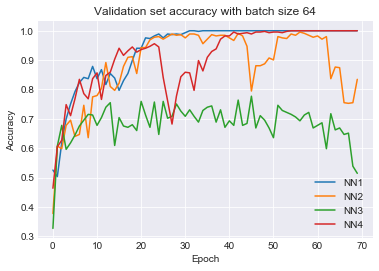

In [8]:
# Plot style
plt.style.use('seaborn-darkgrid')

epochs = 70
batch_size = 64

plt.plot(info1.history['accuracy'], label='NN1')
plt.plot(info2.history['accuracy'], label='NN2')
plt.plot(info3.history['accuracy'], label='NN3')
plt.plot(info4.history['accuracy'], label='NN4')
plt.title('Validation set accuracy with batch size {}'.format(batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('imgs/val_accuracy_noFeatures_epochs{}'.format(epochs))

# Modelos NN sin features: NN1, NN2, NN3, NN4

In [9]:
########################################### NN1 ########################################### 
# Clear
tf.keras.backend.clear_session()
# Model
model1 = tf.keras.Sequential()
# Add layers
model1.add(tf.keras.layers.Flatten(input_shape=(512, 512)))
model1.add(tf.keras.layers.Dense(100, activation='relu'))
model1.add(tf.keras.layers.Dense(3))
########################################### NN2 ########################################### 
# Model
model2 = tf.keras.Sequential()
# Add layers.
model2.add(tf.keras.layers.Flatten(input_shape=(512, 512)))
model2.add(tf.keras.layers.Dense(100, activation='relu'))
model2.add(tf.keras.layers.Dense(100, activation='relu'))
model2.add(tf.keras.layers.Dense(3))
########################################### NN3 ########################################### 
# Model
model3 = tf.keras.Sequential()
# Add layers
model3.add(tf.keras.layers.Flatten(input_shape=(512, 512)))
model3.add(tf.keras.layers.Dense(50, activation='relu'))
model3.add(tf.keras.layers.Dense(3))
########################################### NN4 ########################################### 
# Model
model4 = tf.keras.Sequential()
# Add layers
model4.add(tf.keras.layers.Flatten(input_shape=(512, 512)))
model4.add(tf.keras.layers.Dense(50, activation='relu'))
model4.add(tf.keras.layers.Dense(50, activation='relu'))
model4.add(tf.keras.layers.Dense(3))

In [10]:
# Hyperparameters
n_epochs = 45
batch_size = 64

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
model1.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model2.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model3.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model4.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Fit
tini = time.time()
history1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, y_test),
                    verbose=0)
print('25%, time: {} min'.format((time.time() - tini) / 60))
tini = time.time()
history2 = model2.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, y_test),
                    verbose=0)
print('50%, time: {} min'.format((time.time() - tini) / 60))
tini = time.time()
history3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, y_test),
                    verbose=0)
print('75%, time: {} min'.format((time.time() - tini) / 60))
tini = time.time()
history4 = model4.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, y_test),
                    verbose=0)
print('100%, time: {} min'.format((time.time() - tini) / 60))
tfin = time.time()

print('Training finished -> n_epochs: {}, batch_size: {}'.format(n_epochs, batch_size))

25%, time: 9.603726279735564 min
50%, time: 9.536833369731903 min
75%, time: 6.924920348326365 min
100%, time: 6.696764421463013 min
Training finished -> n_epochs: 45, batch_size: 64


# Comparación de accuracy NN's sin features

In [11]:
acc = []
acc.append([history1.history['val_accuracy'][n_epochs - 1], history1.history['accuracy'][n_epochs - 1]])
acc.append([history2.history['val_accuracy'][n_epochs - 1], history2.history['accuracy'][n_epochs - 1]])
acc.append([history3.history['val_accuracy'][n_epochs - 1], history3.history['accuracy'][n_epochs - 1]])
acc.append([history4.history['val_accuracy'][n_epochs - 1], history4.history['accuracy'][n_epochs - 1]])
for i in range(4):
    print('Model NN{}:'.format(i + 1))
    print('Test acc: {}, Train acc: {}'.format(acc[i][0], acc[i][1]))
    print('---------------------------------------------------------------')


Model NN1:
Test acc: 0.8366445899009705, Train acc: 0.9682915210723877
---------------------------------------------------------------
Model NN2:
Test acc: 0.8322295546531677, Train acc: 0.8793184757232666
---------------------------------------------------------------
Model NN3:
Test acc: 0.8189845681190491, Train acc: 0.9716043472290039
---------------------------------------------------------------
Model NN4:
Test acc: 0.8675496578216553, Train acc: 0.9716043472290039
---------------------------------------------------------------


# Plot comparativo sobre los NN sin features

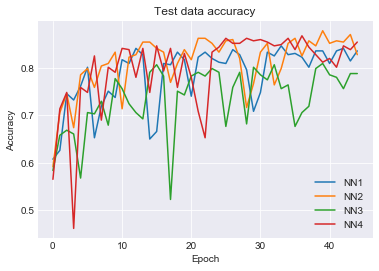

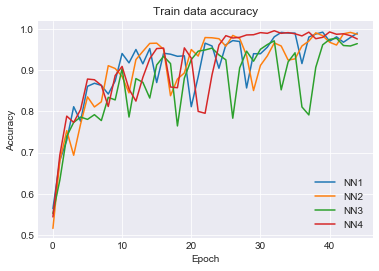

In [21]:
# Plot style.
plt.style.use('seaborn-darkgrid')
x = range(n_epochs)
######################################### Test Data #########################################
plt.plot(x, history1.history['val_accuracy'], label='NN1')
plt.plot(x, history2.history['val_accuracy'], label='NN2')
plt.plot(x, history3.history['val_accuracy'], label='NN3')
plt.plot(x, history4.history['val_accuracy'], label='NN4')
plt.title('Test data accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('imgs/test_accuracy_noFeatures_epochs{}'.format(n_epochs))
plt.show()
######################################### Train Data #########################################
plt.plot(x, history1.history['accuracy'], label='NN1')
plt.plot(x, history2.history['accuracy'], label='NN2')
plt.plot(x, history3.history['accuracy'], label='NN3')
plt.plot(x, history4.history['accuracy'], label='NN4')
plt.title('Train data accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('imgs/train_accuracy_noFeatures_epochs{}'.format(n_epochs))
plt.show()

# Quinto modelo NN5-ft
Se extraen features y se usa NN2

In [3]:
# Tarda al rededor de 51 minutos en procesar todas las imágenes.

ppc = 16
X_ft = []
hog_images = []
tini = time.time()
for image in X:
    ft, hog_image  = hog(image, orientations=9, pixels_per_cell=(ppc,ppc), cells_per_block=(1, 1), 
                         visualize=True)
    X_ft.append(ft)
    hog_images.append(hog_image)
tfin = time.time()
print('Tiempo (min) en obtener features: {}'.format((tfin - tini)/60))


y_ft = y


Tiempo (min) en obtener features: 49.61284935077031


In [22]:
# Data split
X_ft = np.array(X_ft)
X_ft_train, X_aux, y_ft_train, y_aux = train_test_split(X_ft, y_ft, test_size=0.30, random_state=6)
X_ft_val, X_ft_test, y_ft_val, y_ft_test = train_test_split(X_aux, y_aux, test_size=0.50, random_state=7)

#X_ft_train = np.array(X_ft_train)
#X_ft_test = np.array(X_ft_test)
#y_ft_train = np.array(y_ft_train)



In [23]:
print('Input size: {}'.format(X_ft_train[0].shape))

Input size: (9216,)


In [24]:
# Clear
tf.keras.backend.clear_session()

# Model
model5 = tf.keras.Sequential()

# Add input layer.
model5.add(tf.keras.layers.InputLayer(input_shape=(9216,)))

# Add hidden layers.
model5.add(tf.keras.layers.Dense(100, activation='relu'))
model5.add(tf.keras.layers.Dense(100, activation='relu'))

# Output layer.
model5.add(tf.keras.layers.Dense(3))

model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               921700    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 932,103
Trainable params: 932,103
Non-trainable params: 0
_________________________________________________________________


In [27]:
batch_size = 32
n_epochs = 4

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
model5.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Fit
tini = time.time()
history5 = model5.fit(X_ft_train, y_ft_train, batch_size=batch_size, epochs=n_epochs, verbose=1
                      validation_data=(X_ft_test, y_ft_test), verbose=1)
tfin = time.time()
print('Trainig time: {} min, n_epochs: {}, batch_size: {}'.format((tfin - tini) / 60, n_epochs, batch_size))

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'numpy.float64'>"})

# Plot comparativo: Dos figuras.